In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
from scipy import signal
from scipy.signal import windows
from scipy.signal import periodogram as periodogram_f

In [70]:
# read data
df = pd.read_excel("../data/control_6_min_week2.xlsx", sheet_name="systolicbp_week2", index_col="time")

In [71]:
df

,rat_id,treatment,systolic_bp
time,,,
0,2,L12-VH,152.874547
1,2,L12-VH,152.074223
2,2,L12-VH,151.965138
3,2,L12-VH,158.461343
4,2,L12-VH,150.355768
...,...,...,...
502,2,L12-VH,140.760028
503,2,L12-VH,137.802220
504,2,L12-VH,136.144749


In [72]:
# get rat id 2 data only
df_ratid = df[df["rat_id"] == 2]

In [113]:
df_ratid.head(2)

,rat_id,treatment,systolic_bp
time,,,
0,2,L12-VH,152.874547
1,2,L12-VH,152.074223


In [74]:
df_ratid.shape

(507, 3)

## Periodogram

In [78]:
# 1. Define sampling rate
# 1 cycle is a day then sampling rate is 24
data_len = df_ratid.shape[0]  # df_ratid.shape[0]
rate = 10  # in 1 hour we have 10 samples (each 6 mins)
time = np.arange(0, data_len, 1) / rate 

$$ 0/10,1/10,2/10,...,11/10,12/10,..,506/10)$$

In [481]:
time[:20]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [80]:
vals = df_ratid["systolic_bp"].values

In [487]:
# fourier frequencies
(1 / fftfreq(vals.shape[0], d=1/rate)[1:])[:10]

array([50.7       , 25.35      , 16.9       , 12.675     , 10.14      ,
        8.45      ,  7.24285714,  6.3375    ,  5.63333333,  5.07      ])

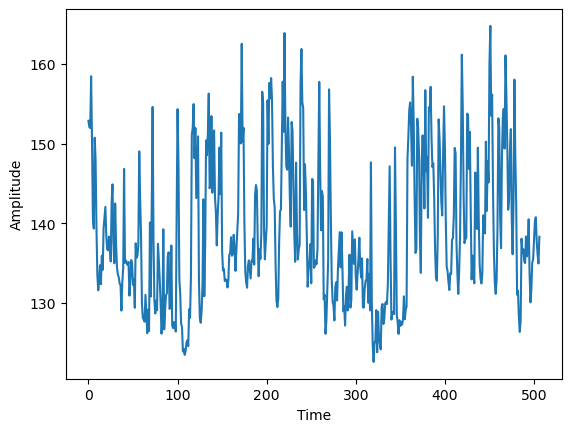

In [86]:
plt.plot(vals)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

In [488]:
# hann window for smoothing the series
hann_window = windows.hann(vals.shape[0])

freqs, power = periodogram_f(
    vals - np.mean(vals),
    fs=rate, 
    window=hann_window, 
    nfft=None, 
    detrend=None, 
    return_onesided=True, 
    scaling="spectrum"
)

Text(0, 0.5, ' Power spectrum [V**2/Hz]')

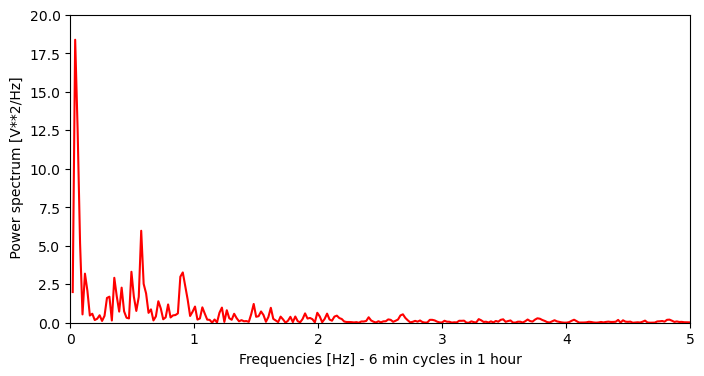

In [489]:
plt.figure(figsize=(8,4))
plt.plot(freqs[1:], power[1:], color="r")
plt.xlim(0,5)
plt.ylim(bottom=0, top=20)
plt.xlabel("Frequencies [Hz] - 6 min cycles in 1 hour")
plt.ylabel(" Power spectrum [V**2/Hz]")

In [490]:
df = pd.DataFrame(data=np.column_stack((np.absolute(power[1:]), 1/freqs[1:])), columns=("PowerSpectrum", 'Freq'))
print(df.nlargest(5, columns="PowerSpectrum").to_string(index=False))

 PowerSpectrum      Freq
     18.375452 25.350000
     12.553184 16.900000
      5.971199  1.748276
      5.166278 12.675000
      3.308138  2.028000


# Lomb Scargle Periodogram

In [327]:
!pip install astropy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 38.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.0/696.0 kB 43.2 MB/s eta 0:00:00


In [437]:
from astropy.timeseries import LombScargle

# center values
centered = vals - np.mean(vals)

# create a lomb scargle object
ls = LombScargle(time, centered)

# compute with a min freq of the total data points and a max freq of 1 hour
frequency, power = ls.autopower(
    minimum_frequency=1/vals.shape[0],
    maximum_frequency=1
)

In [438]:
power[:15]

array([0.01839488, 0.01824308, 0.01746896, 0.01482095, 0.00830067,
       0.000381  , 0.00888411, 0.04335562, 0.09474144, 0.15803425,
       0.21176731, 0.20848164, 0.14849048, 0.08243005, 0.03521507])

In [439]:
1/frequency[:15]

array([507.        , 168.77763158, 101.23993686,  72.30608794,
        56.23454625,  46.00824964,  38.92898331,  33.73776959,
        29.76815967,  26.63434385,  24.09750141,  22.00188679,
        20.24159697,  18.74210988,  17.44946266])

(0.0, 50.0)

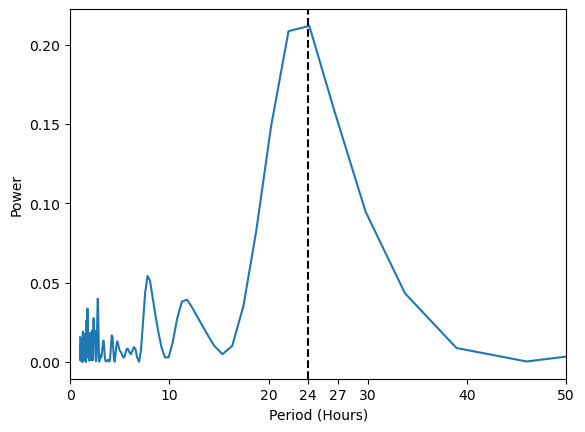

In [471]:
fig, ax = plt.subplots()
ax.plot(1/frequency, power)
ax.set_ylabel("Power")
ax.set_xlabel("Period (Hours)")
ax.axvline(24, color="k", ls="--")
ax.set_xticks([0, 10, 20, 24, 27, 30, 40, 50])
ax.set_xlim(0,50)

(19.0, 27.0)

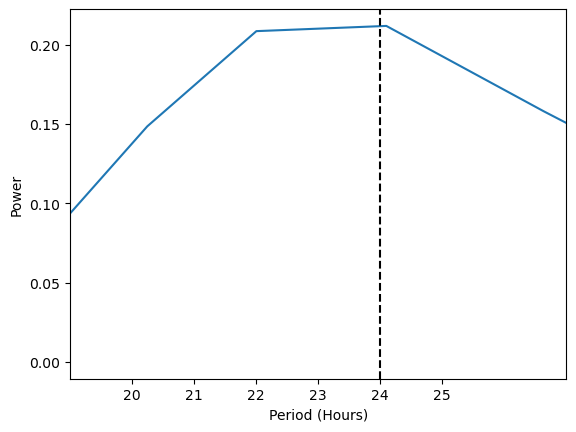

In [479]:
fig, ax = plt.subplots()
ax.plot(1/frequency, power)
ax.set_ylabel("Power")
ax.set_xlabel("Period (Hours)")
ax.axvline(24, color="k", ls="--")
ax.set_xticks([i for i in range(20, 26)])
ax.set_xlim(19,27)

In [441]:
print(power.max())

0.21176731457686898


In [443]:
ls.false_alarm_probability(power.max()) * 100

9.68938474792608e-21

What this tells us is that under the assumption that there is no periodic signal in the data, we will observe a peak this high or higher approximately 0.00000000000...% of the time, which gives a strong indication that a periodic signal is present in the data.

In [444]:
probabilities = [0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.0412387 , 0.04410663, 0.05053861])

In [446]:
ls.false_alarm_probability(power.max(), method='bootstrap')

0.0